In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r'C:\Users\zbh\Desktop\uber_dataset.csv')
df['dateSurvey'] = pd.to_datetime(df['dateSurvey'])

# Check for duplicates first
print("Checking for duplicate agency-date combinations...")
duplicates = df.groupby(['agency', 'dateSurvey']).size()
print(f"Total duplicate combinations: {(duplicates > 1).sum()}")

Checking for duplicate agency-date combinations...
Total duplicate combinations: 165


In [4]:
# Aggregate duplicates by taking mean for continuous variables and first for treatment
print("Aggregating duplicate observations...")
clean_df = df.groupby(['agency', 'dateSurvey']).agg({
    'UPTTotal': 'mean',
    'treatUberX': 'first',  # Treatment status should be same within agency-month
    'treatGTNotStd': 'mean',
    'gasPrice': 'mean',
    'employment': 'mean',
    'aveFareTotal': 'mean',
    'popestimate': 'mean',
    'VRHTotal': 'mean',
    'VOMSTotal': 'mean',
    'VRMTotal': 'mean',
    'city': 'first',
    'state': 'first'
}).reset_index()

# Create additional variables
clean_df['agency_id'] = clean_df['agency'].astype('category').cat.codes
clean_df['year'] = clean_df['dateSurvey'].dt.year
clean_df['month'] = clean_df['dateSurvey'].dt.month
clean_df['year_month'] = clean_df['year'].astype(str) + '_' + clean_df['month'].astype(str)

# Remove observations with missing key variables
clean_df = clean_df.dropna(subset=['UPTTotal', 'treatUberX', 'treatGTNotStd', 'gasPrice', 
                                   'employment', 'aveFareTotal']).reset_index(drop=True)

# Create log transformation of dependent variable
clean_df['log_UPTTotal'] = np.log(clean_df['UPTTotal'])

print(f"Final dataset: {len(clean_df)} observations")
print(f"Number of agencies: {clean_df['agency'].nunique()}")
print(f"Time period: {clean_df['dateSurvey'].min()} to {clean_df['dateSurvey'].max()}")

Aggregating duplicate observations...
Final dataset: 58379 observations
Number of agencies: 545
Time period: 2004-01-01 00:00:00 to 2015-12-01 00:00:00


In [5]:
# Model 1: Fixed Effects Regression with treatUberX
print("\n" + "=" * 60)
print("MODEL 1: Fixed Effects Regression with treatUberX")
print("=" * 60)

formula1 = 'log_UPTTotal ~ treatUberX + gasPrice + employment + aveFareTotal + C(agency_id) + C(year_month)'
model1 = ols(formula1, data=clean_df).fit()

print("Regression Results - Model 1:")
print(model1.summary().tables[1])
print(f"\nR-squared: {model1.rsquared:.4f}")
print(f"Adjusted R-squared: {model1.rsquared_adj:.4f}")
print(f"Number of observations: {int(model1.nobs)}")


MODEL 1: Fixed Effects Regression with treatUberX
Regression Results - Model 1:
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   11.4815      0.041    281.433      0.000      11.402      11.561
C(agency_id)[T.2]           -0.7934      0.135     -5.873      0.000      -1.058      -0.529
C(agency_id)[T.3]           -0.6873      0.095     -7.271      0.000      -0.873      -0.502
C(agency_id)[T.4]           -2.9333      0.136    -21.552      0.000      -3.200      -2.667
C(agency_id)[T.5]            3.3442      0.047     71.512      0.000       3.252       3.436
C(agency_id)[T.6]           -2.8025      0.067    -41.555      0.000      -2.935      -2.670
C(agency_id)[T.7]           -3.7472      0.043    -87.057      0.000      -3.832      -3.663
C(agency_id)[T.8]           -0.4767      0.036    -13.200      0.000      -0.547  

In [6]:
# Extract key coefficient
uber_coef1 = model1.params['treatUberX']
uber_pvalue1 = model1.pvalues['treatUberX']
uber_conf_int1 = model1.conf_int().loc['treatUberX']

print(f"\n--- KEY RESULTS FOR MODEL 1 ---")
print(f"treatUberX coefficient: {uber_coef1:.4f}")
print(f"Standard error: {model1.bse['treatUberX']:.4f}")
print(f"t-statistic: {model1.tvalues['treatUberX']:.4f}")
print(f"p-value: {uber_pvalue1:.4f}")
print(f"95% Confidence Interval: [{uber_conf_int1[0]:.4f}, {uber_conf_int1[1]:.4f}]")

if uber_pvalue1 < 0.05:
    interpretation1 = "SUBSTITUTE" if uber_coef1 < 0 else "COMPLEMENT"
    effect_size = (np.exp(uber_coef1) - 1) * 100
    print(f"*** SIGNIFICANT RESULT: Uber appears to be a {interpretation1} for public transit ***")
    print(f"Effect size: {effect_size:.2f}% change in ridership when Uber is present")
else:
    print("*** NO SIGNIFICANT RELATIONSHIP FOUND ***")



--- KEY RESULTS FOR MODEL 1 ---
treatUberX coefficient: -0.0418
Standard error: 0.0066
t-statistic: -6.3611
p-value: 0.0000
95% Confidence Interval: [-0.0547, -0.0289]
*** SIGNIFICANT RESULT: Uber appears to be a SUBSTITUTE for public transit ***
Effect size: -4.10% change in ridership when Uber is present


In [7]:
# Model 2: Fixed Effects Regression with treatGTNotStd
print("\n" + "=" * 60)
print("MODEL 2: Fixed Effects Regression with treatGTNotStd")
print("=" * 60)

formula2 = 'log_UPTTotal ~ treatGTNotStd + gasPrice + employment + aveFareTotal + C(agency_id) + C(year_month)'
model2 = ols(formula2, data=clean_df).fit()

print("Regression Results - Model 2:")
print(model2.summary().tables[1])
print(f"\nR-squared: {model2.rsquared:.4f}")
print(f"Adjusted R-squared: {model2.rsquared_adj:.4f}")
print(f"Number of observations: {int(model2.nobs)}")


MODEL 2: Fixed Effects Regression with treatGTNotStd
Regression Results - Model 2:
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   11.4851      0.041    280.547      0.000      11.405      11.565
C(agency_id)[T.2]           -0.7489      0.139     -5.388      0.000      -1.021      -0.477
C(agency_id)[T.3]           -0.6562      0.097     -6.766      0.000      -0.846      -0.466
C(agency_id)[T.4]           -2.8901      0.140    -20.644      0.000      -3.164      -2.616
C(agency_id)[T.5]            3.3533      0.047     70.925      0.000       3.261       3.446
C(agency_id)[T.6]           -2.7980      0.068    -41.418      0.000      -2.930      -2.666
C(agency_id)[T.7]           -3.7455      0.043    -86.994      0.000      -3.830      -3.661
C(agency_id)[T.8]           -0.4749      0.036    -13.144      0.000      -0.54

In [9]:
# Extract key coefficient
uber_coef2 = model2.params['treatGTNotStd']
uber_pvalue2 = model2.pvalues['treatGTNotStd']
uber_conf_int2 = model2.conf_int().loc['treatGTNotStd']

print(f"\n--- KEY RESULTS FOR MODEL 2 ---")
print(f"treatGTNotStd coefficient: {uber_coef2:.4f}")
print(f"Standard error: {model2.bse['treatGTNotStd']:.4f}")
print(f"t-statistic: {model2.tvalues['treatGTNotStd']:.4f}")
print(f"p-value: {uber_pvalue2:.4f}")
print(f"95% Confidence Interval: [{uber_conf_int2[0]:.4f}, {uber_conf_int2[1]:.4f}]")

if uber_pvalue2 < 0.05:
    interpretation2 = "SUBSTITUTE" if uber_coef2 < 0 else "COMPLEMENT"
    print(f"*** SIGNIFICANT RESULT: Uber appears to be a {interpretation2} for public transit ***")
    print(f"One unit increase in Google search intensity → {uber_coef2:.4f} change in log ridership")
else:
    print("*** NO SIGNIFICANT RELATIONSHIP FOUND ***")


--- KEY RESULTS FOR MODEL 2 ---
treatGTNotStd coefficient: -0.0015
Standard error: 0.0006
t-statistic: -2.5596
p-value: 0.0105
95% Confidence Interval: [-0.0027, -0.0004]
*** SIGNIFICANT RESULT: Uber appears to be a SUBSTITUTE for public transit ***
One unit increase in Google search intensity → -0.0015 change in log ridership


In [10]:
# Summary Table
print("\n" + "=" * 60)
print("REGRESSION SUMMARY TABLE")
print("=" * 60)

summary_table = pd.DataFrame({
    'Model': ['Model 1: Binary Uber Presence', 'Model 2: Google Search Intensity'],
    'Variable': ['treatUberX', 'treatGTNotStd'],
    'Coefficient': [uber_coef1, uber_coef2],
    'Std Error': [model1.bse['treatUberX'], model2.bse['treatGTNotStd']],
    'p-value': [uber_pvalue1, uber_pvalue2],
    'Significant': ['Yes' if uber_pvalue1 < 0.05 else 'No', 'Yes' if uber_pvalue2 < 0.05 else 'No'],
    'R-squared': [model1.rsquared, model2.rsquared],
    'N': [int(model1.nobs), int(model2.nobs)]
})

print(summary_table.round(4).to_string(index=False))


REGRESSION SUMMARY TABLE
                           Model      Variable  Coefficient  Std Error  p-value Significant  R-squared     N
   Model 1: Binary Uber Presence    treatUberX      -0.0418     0.0066   0.0000         Yes     0.9775 58379
Model 2: Google Search Intensity treatGTNotStd      -0.0015     0.0006   0.0105         Yes     0.9775 58379


In [11]:
# Overall Conclusion
print("\n" + "=" * 60)
print("FINAL INTERPRETATION & POLICY IMPLICATIONS")
print("=" * 60)

significant_results = []
if uber_pvalue1 < 0.05:
    significant_results.append(('Binary Uber presence', uber_coef1, interpretation1))
if uber_pvalue2 < 0.05:
    significant_results.append(('Google search intensity', uber_coef2, interpretation2))

if significant_results:
    print("MAIN FINDINGS:")
    for var_name, coef, interp in significant_results:
        print(f"• {var_name}: {interp} effect (coefficient = {coef:.4f})")
    
    # Determine overall conclusion
    if all(result[1] < 0 for result in significant_results):
        overall_conclusion = "SUBSTITUTE"
        policy_implication = "Uber reduces public transit ridership. Policymakers should consider this when regulating ride-sharing services."
    elif all(result[1] > 0 for result in significant_results):
        overall_conclusion = "COMPLEMENT" 
        policy_implication = "Uber enhances public transit usage, likely through first-mile/last-mile connectivity. This suggests potential for integration."
    else:
        overall_conclusion = "MIXED EVIDENCE"
        policy_implication = "Results vary by measure. Further investigation needed to understand the relationship."
    
    print(f"\n*** OVERALL CONCLUSION: Uber acts as a {overall_conclusion} to public transit ***")
    print(f"POLICY IMPLICATION: {policy_implication}")
    
else:
    print("*** NO SIGNIFICANT RELATIONSHIP FOUND ***")
    print("The evidence is insufficient to determine whether Uber acts as a substitute or complement.")
    print("POLICY IMPLICATION: Current data suggests minimal impact of Uber on public transit ridership.")

print(f"\nMETHODOLOGY NOTE:")
print(f"• Used fixed effects panel regression controlling for agency and time heterogeneity")
print(f"• Log-linear specification allows for percentage interpretation of effects")
print(f"• Robust to unobserved agency characteristics and common time trends")
print(f"• Sample includes {clean_df['agency'].nunique()} transit agencies over {clean_df['year'].nunique()} years")


FINAL INTERPRETATION & POLICY IMPLICATIONS
MAIN FINDINGS:
• Binary Uber presence: SUBSTITUTE effect (coefficient = -0.0418)
• Google search intensity: SUBSTITUTE effect (coefficient = -0.0015)

*** OVERALL CONCLUSION: Uber acts as a SUBSTITUTE to public transit ***
POLICY IMPLICATION: Uber reduces public transit ridership. Policymakers should consider this when regulating ride-sharing services.

METHODOLOGY NOTE:
• Used fixed effects panel regression controlling for agency and time heterogeneity
• Log-linear specification allows for percentage interpretation of effects
• Robust to unobserved agency characteristics and common time trends
• Sample includes 545 transit agencies over 12 years


In [19]:
#part B done

In [ ]:
# Robustness Checks

In [21]:
# Conduct sub-sample analysis (high vs low population, high vs low gas prices)
# Define high and low population groups: divide by the median
pop_median = clean_df['popestimate'].median()
high_pop = clean_df[clean_df['popestimate'] >= pop_median]
low_pop = clean_df[clean_df['popestimate'] < pop_median]

formula = 'log_UPTTotal ~ treatUberX + gasPrice + employment + aveFareTotal + C(agency_id) + C(year_month)'

# High population group regression
model_high_pop = ols(formula, data=high_pop).fit()
print("High population group regression results:")
print(model_high_pop.summary().tables[1])

# Low population group regression
model_low_pop = ols(formula, data=low_pop).fit()
print("Low population group regression results:")
print(model_low_pop.summary().tables[1])

High population group regression results:
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   11.6470      0.172     67.561      0.000      11.309      11.985
C(agency_id)[T.3]           -0.2368      0.064     -3.690      0.000      -0.363      -0.111
C(agency_id)[T.4]           -2.0430      0.038    -53.903      0.000      -2.117      -1.969
C(agency_id)[T.5]            3.3918      0.130     26.174      0.000       3.138       3.646
C(agency_id)[T.6]           -2.8819      0.163    -17.722      0.000      -3.201      -2.563
C(agency_id)[T.14]           0.4877      0.067      7.317      0.000       0.357       0.618
C(agency_id)[T.16]          -0.2738      0.145     -1.887      0.059      -0.558       0.011
C(agency_id)[T.17]          -0.0517      0.066     -0.779      0.436      -0.182       0.078
C(agency_id)[T.18]          

In [22]:
# Define high and low gas price groups: divide by the median
gas_median = clean_df['gasPrice'].median()
high_gas = clean_df[clean_df['gasPrice'] >= gas_median]
low_gas = clean_df[clean_df['gasPrice'] < gas_median]

# High gas price group regression
model_high_gas = ols(formula, data=high_gas).fit()
print("High gas price group regression results:")
print(model_high_gas.summary().tables[1])

# Low gas price group regression
model_low_gas = ols(formula, data=low_gas).fit()
print("Low gas price group regression results:")
print(model_low_gas.summary().tables[1])

High gas price group regression results:
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   11.8509      0.084    141.292      0.000      11.687      12.015
C(agency_id)[T.2]           -0.8955      0.214     -4.188      0.000      -1.315      -0.476
C(agency_id)[T.3]           -0.5199      0.146     -3.553      0.000      -0.807      -0.233
C(agency_id)[T.4]           -2.8909      0.214    -13.497      0.000      -3.311      -2.471
C(agency_id)[T.5]            3.2997      0.067     49.180      0.000       3.168       3.431
C(agency_id)[T.6]           -2.7912      0.084    -33.107      0.000      -2.956      -2.626
C(agency_id)[T.7]           -3.5679      0.058    -61.682      0.000      -3.681      -3.455
C(agency_id)[T.8]           -0.4200      0.050     -8.368      0.000      -0.518      -0.322
C(agency_id)[T.10]          -

In [23]:
# Add the lag term of the Uber variable
clean_df = clean_df.sort_values(['agency', 'dateSurvey'])
clean_df['treatUberX_lag1'] = clean_df.groupby('agency')['treatUberX'].shift(1)

# Remove the lagged variables that are missing in the first period
lagged_df = clean_df.dropna(subset=['treatUberX_lag1'])

formula_lag = 'log_UPTTotal ~ treatUberX + treatUberX_lag1 + gasPrice + employment + aveFareTotal + C(agency_id) + C(year_month)'

model_lag = ols(formula_lag, data=lagged_df).fit()
print("Regression with lagged treatUberX:")
print(model_lag.summary().tables[1])

Regression with lagged treatUberX:
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   11.6073      0.046    251.084      0.000      11.517      11.698
C(agency_id)[T.2]           -0.8309      0.135     -6.135      0.000      -1.096      -0.565
C(agency_id)[T.3]           -0.7066      0.095     -7.464      0.000      -0.892      -0.521
C(agency_id)[T.4]           -2.9603      0.136    -21.703      0.000      -3.228      -2.693
C(agency_id)[T.5]            3.3352      0.047     71.523      0.000       3.244       3.427
C(agency_id)[T.6]           -2.8085      0.068    -41.313      0.000      -2.942      -2.675
C(agency_id)[T.7]           -3.7251      0.043    -86.641      0.000      -3.809      -3.641
C(agency_id)[T.8]           -0.4770      0.036    -13.297      0.000      -0.547      -0.407
C(agency_id)[T.10]          -0.5698

               Model  Coefficient  Std Error  p-value
0    Base treatUberX      -0.0418     0.0066   0.0000
1      treatGTNotStd      -0.0015     0.0006   0.0105
2           High Pop      -0.0717     0.0107   0.0000
3            Low Pop      -0.0449     0.0114   0.0001
4           High Gas      -0.0334     0.0073   0.0000
5            Low Gas      -0.0049     0.0136   0.7193
6  Lagged treatUberX      -0.0186     0.0198   0.3476


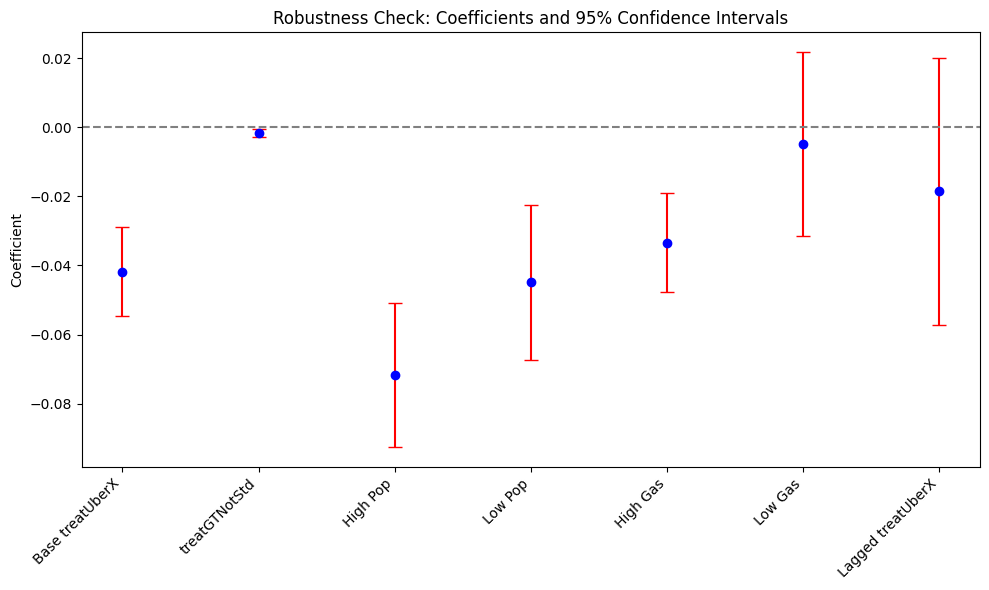

In [28]:
robustness_summary = pd.DataFrame({
    'Model': ['Base treatUberX', 'treatGTNotStd', 'High Pop', 'Low Pop', 'High Gas', 'Low Gas', 'Lagged treatUberX'],
    'Coefficient': [
        model1.params['treatUberX'],
        model2.params['treatGTNotStd'],
        model_high_pop.params.get('treatUberX', float('nan')),
        model_low_pop.params.get('treatUberX', float('nan')),
        model_high_gas.params.get('treatUberX', float('nan')),
        model_low_gas.params.get('treatUberX', float('nan')),
        model_lag.params['treatUberX']
    ],
    'Std Error': [
        model1.bse['treatUberX'],
        model2.bse['treatGTNotStd'],
        model_high_pop.bse.get('treatUberX', float('nan')),
        model_low_pop.bse.get('treatUberX', float('nan')),
        model_high_gas.bse.get('treatUberX', float('nan')),
        model_low_gas.bse.get('treatUberX', float('nan')),
        model_lag.bse['treatUberX']
    ],
    'p-value': [
        model1.pvalues['treatUberX'],
        model2.pvalues['treatGTNotStd'],
        model_high_pop.pvalues.get('treatUberX', float('nan')),
        model_low_pop.pvalues.get('treatUberX', float('nan')),
        model_high_gas.pvalues.get('treatUberX', float('nan')),
        model_low_gas.pvalues.get('treatUberX', float('nan')),
        model_lag.pvalues['treatUberX']
    ],
})

print(robustness_summary.round(4))
# Coefficient graph
plt.figure(figsize=(10,6))
plt.errorbar(x=robustness_summary['Model'], y=robustness_summary['Coefficient'], 
             yerr=1.96*robustness_summary['Std Error'], fmt='o', color='b', ecolor='r', capsize=5)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.title('Robustness Check: Coefficients and 95% Confidence Intervals')
plt.ylabel('Coefficient')
plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

data = {
    "Model Name": [
        "Base treatUberX",
        "treatGTNotStd",
        "High Pop",
        "Low Pop",
        "High Gas",
        "Low Gas",
        "Lagged treatUberX"
    ],
    "Coefficient": [
        -0.0418,
        -0.0015,
        -0.0717,
        -0.0449,
        -0.0334,
        -0.0049,
        -0.0186
    ],
    "Statistically Significant": [
        "Yes",
        "Yes, but very small",
        "Yes",
        "Yes",
        "Yes",
        "No",
        "No"
    ],
    "Interpretation": [
        "After UberX enters, public transit usage drops by about 4.18% on average — the main finding.",
        "Using Google Trends as a proxy shows a minimal effect (-0.15%), suggesting awareness is not the main driver.",
        "In high-population areas, the effect is stronger (−7.17%), indicating a more pronounced substitution.",
        "In low-population areas, the effect exists but is slightly weaker (−4.49%).",
        "In regions with high gas prices, people are more likely to shift to Uber over public transit.",
        "In low gas price areas, the effect is negligible and not statistically significant.",
        "The lagged effect is not significant, indicating the impact is immediate rather than delayed."
    ]
}

df = pd.DataFrame(data)
print(df)

          Model Name  Coefficient Statistically Significant  \
0    Base treatUberX      -0.0418                       Yes   
1      treatGTNotStd      -0.0015       Yes, but very small   
2           High Pop      -0.0717                       Yes   
3            Low Pop      -0.0449                       Yes   
4           High Gas      -0.0334                       Yes   
5            Low Gas      -0.0049                        No   
6  Lagged treatUberX      -0.0186                        No   

                                      Interpretation  
0  After UberX enters, public transit usage drops...  
1  Using Google Trends as a proxy shows a minimal...  
2  In high-population areas, the effect is strong...  
3  In low-population areas, the effect exists but...  
4  In regions with high gas prices, people are mo...  
5  In low gas price areas, the effect is negligib...  
6  The lagged effect is not significant, indicati...  


In [ ]:
# Part c done